In [1]:
import json
import os
import numpy as np
import pandas as pd
from cvdnet_pipeline.simulate_data import simulate_data
from cvdnet_pipeline.analyse_giessen import analyse_giessen
from cvdnet_pipeline.compute_pca import compute_pca
from cvdnet_pipeline.build_emulator import build_emulator
from cvdnet_pipeline.build_emulator_log import build_emulator_log
from cvdnet_pipeline.calibrate_parameters import calibrate_parameters
from cvdnet_pipeline.calibrate_parameters_log import calibrate_parameters_log

In [6]:
input_parameters = "parameters_sensitive_ci_6.json"
output_path = "output_synthetic"
data_type = "synthetic"
n_pca_components = 10
n_params = 6
n_samples = 4096
gaussian_sigmas = [1e-05, 1e-05, 1e-05]

output_keys = [
    "edp",
    "dia",
    "epad",
    "eivc",
    "sys",
    "esp",
    "a_epad",
    "P_max",
    "EF",
    "Ees/Ea",
    "iT"
]

include_timeseries = 0
epsilon_obs_scale = 0.05
dummy_data_dir = "dummy_data"

In [ ]:
print("Simulating Data")
output_dir_sims, n_params = simulate_data(param_path=os.path.join('input_parameters_jsons', input_parameters),
              n_samples=n_samples,
              output_path=output_path,
              sample_parameters=True)

In [ ]:
print("Step 2: Analysing Giessen (resample)")
analyse_giessen(file_path=output_dir_sims,
                            data_type="synthetic",
                            gaussian_sigmas=gaussian_sigmas)

In [ ]:
print("Step 3: Compute PCA")
compute_pca(n_samples=n_samples, 
            n_params=n_params, 
            n_pca_components=n_pca_components,
            output_path=output_path,
            data_type=data_type)

In [7]:
print("Step 4: Building Emulator")
filtered_input_mean = build_emulator_log(n_samples=n_samples,
            n_params=n_params, 
            output_path=output_path, 
            output_file_name="waveform_resampled_all_pressure_traces_rv_with_pca.csv",
            output_keys_red=output_keys)

Step 4: Building Emulator


Step 5: Calibrating Parameters


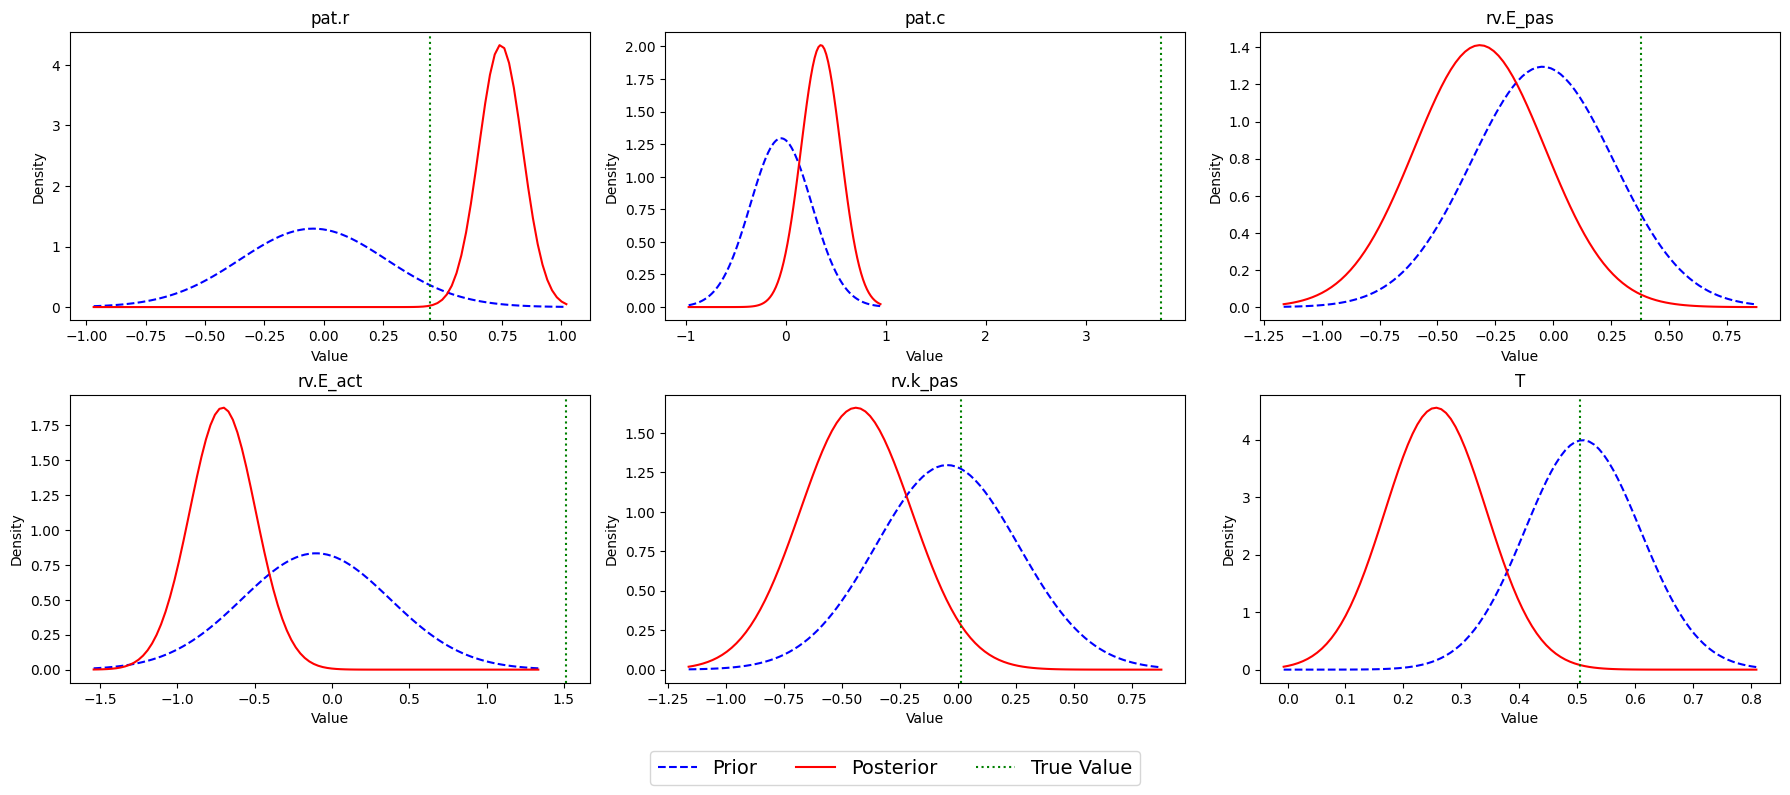

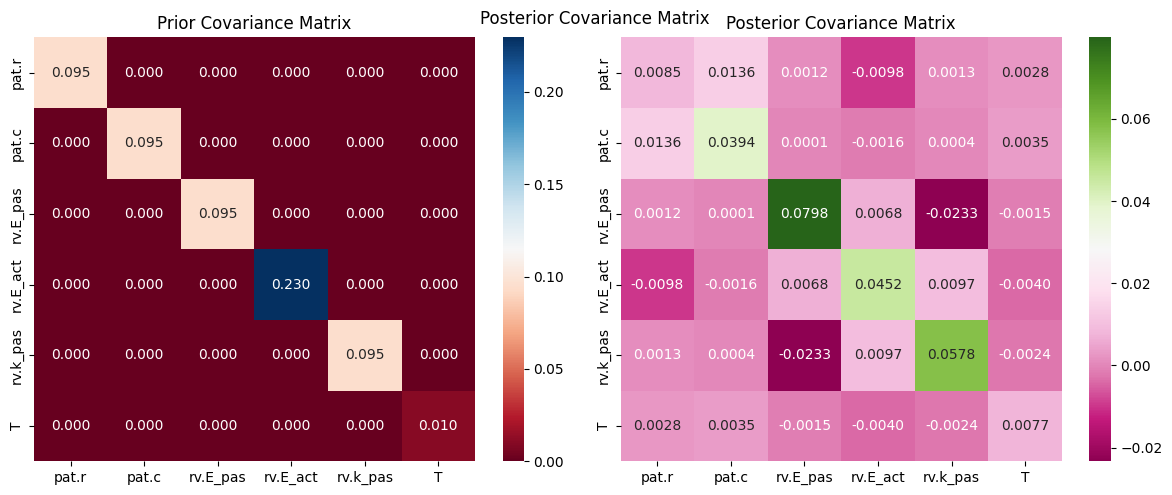

In [8]:
print("Step 5: Calibrating Parameters")
output_dir_bayesian, e_obs, samples_df_exp = calibrate_parameters_log(
data_type=data_type,
n_samples=n_samples,
n_params=n_params,
output_path=output_path,
output_keys=output_keys,
include_timeseries=include_timeseries,
epsilon_obs_scale= epsilon_obs_scale,
dummy_data_dir=dummy_data_dir,
config=None)

In [17]:

mu_theta = pd.read_csv("output_synthetic/output_4096_6_params/bayesian_calibration_results/11_output_keys/calibration_20250918_164831/posterior_mean.csv")
Sigma_theta = pd.read_csv("output_synthetic/output_4096_6_params/bayesian_calibration_results/11_output_keys/calibration_20250918_164831/posterior_covariance.csv")

mu_theta = np.array(mu_theta).squeeze()
Sigma_theta = np.array(Sigma_theta)

mean_vals = filtered_input_mean 
m = np.array(mean_vals)

# --- Analytic marginal summaries ---
sigma2 = np.diag(Sigma_theta)
sigma = np.sqrt(sigma2)

E_p = m * np.exp(mu_theta + 0.5 * sigma2)             # posterior mean of p
Var_p = (m**2) * np.exp(2*mu_theta + sigma2) * (np.exp(sigma2) - 1)
median_p = m * np.exp(mu_theta)
mode_p = m * np.exp(mu_theta - sigma2)

E_p, Var_p, median_p, mode_p

(array([[0.65538413, 5.51251048, 0.50786284, 1.01638572, 0.01327093,
         0.88179225]]),
 array([[3.65527678e-03, 1.21976884e+00, 2.14373796e-02, 4.77973186e-02,
         1.04878032e-05, 5.99098553e-03]]),
 array([[0.65261315, 5.40509714, 0.48798803, 0.99365806, 0.01289261,
         0.8784147 ]]),
 array([[0.64710629, 5.19650865, 0.45054134, 0.94971602, 0.012168  ,
         0.87169837]]))

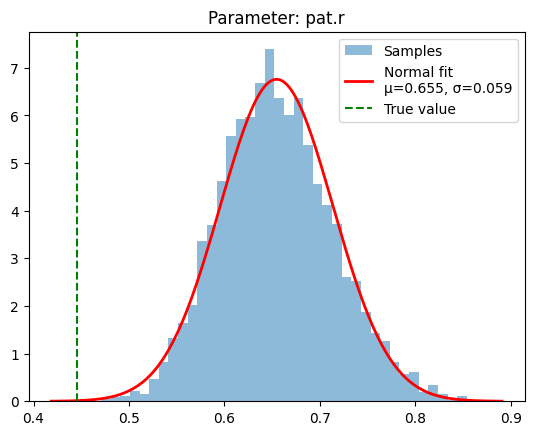

pat.r       0.310000
pat.c       3.800000
rv.E_pas    0.670000
rv.E_act    2.012500
rv.k_pas    0.019999
T           0.680000
Name: 0, dtype: float64


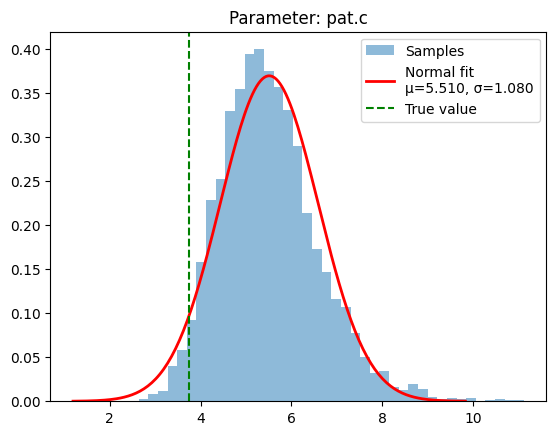

pat.r       0.310000
pat.c       3.800000
rv.E_pas    0.670000
rv.E_act    2.012500
rv.k_pas    0.019999
T           0.680000
Name: 0, dtype: float64


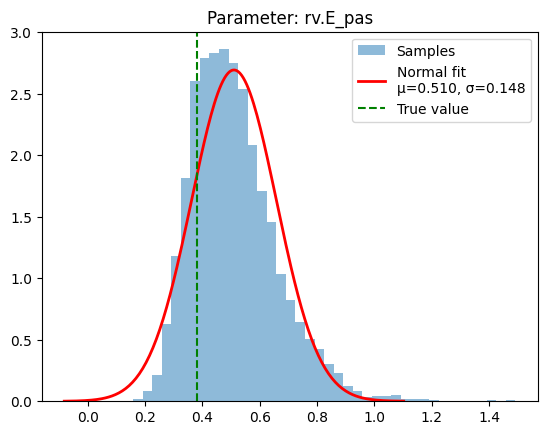

pat.r       0.310000
pat.c       3.800000
rv.E_pas    0.670000
rv.E_act    2.012500
rv.k_pas    0.019999
T           0.680000
Name: 0, dtype: float64


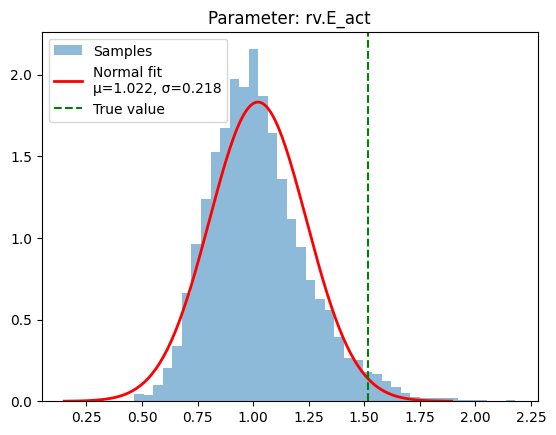

pat.r       0.310000
pat.c       3.800000
rv.E_pas    0.670000
rv.E_act    2.012500
rv.k_pas    0.019999
T           0.680000
Name: 0, dtype: float64


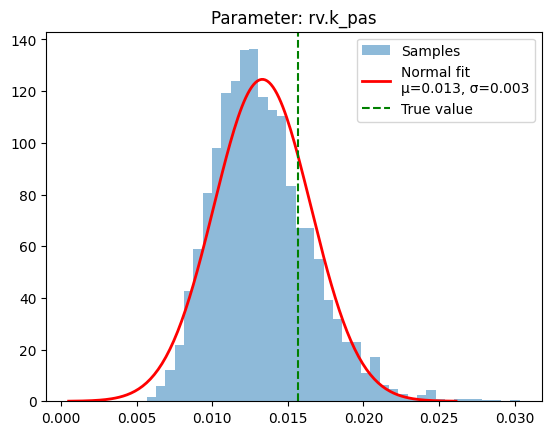

pat.r       0.310000
pat.c       3.800000
rv.E_pas    0.670000
rv.E_act    2.012500
rv.k_pas    0.019999
T           0.680000
Name: 0, dtype: float64


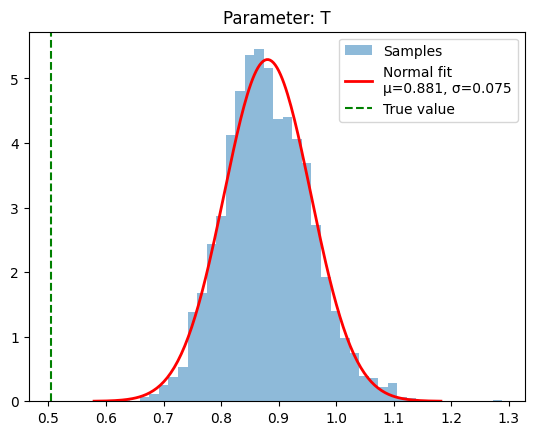

pat.r       0.310000
pat.c       3.800000
rv.E_pas    0.670000
rv.E_act    2.012500
rv.k_pas    0.019999
T           0.680000
Name: 0, dtype: float64


In [14]:
from matplotlib import pyplot as plt
from scipy.stats import norm

# Load files
true = pd.read_csv(f"{dummy_data_dir}/pure_input_dummy_data.csv")
posterior = samples_df_exp
mean_vals = filtered_input_mean 

# Select observation:
which_obs = 3
true_obs = true.iloc[which_obs]

# Convert 1x6 row into a Series
scales = mean_vals.iloc[0]

# Scale posterior samples column-wise
scaled_posterior = posterior * scales

# Plot normal pdfs for each parameter
x_points = 200  # resolution for plotting

for col in scaled_posterior.columns:
    data = scaled_posterior[col].values
    mu, sigma = np.mean(data), np.std(data)

    x = np.linspace(mu - 4*sigma, mu + 4*sigma, x_points)
    pdf = norm.pdf(x, mu, sigma)

    plt.figure()
    plt.hist(data, bins=40, density=True, alpha=0.5, label="Samples")
    plt.plot(x, pdf, 'r-', lw=2, label=f"Normal fit\nμ={mu:.3f}, σ={sigma:.3f}")
    plt.axvline(true_obs[col], color='g', linestyle='--', label="True value")
    plt.title(f"Parameter: {col}")
    plt.legend()
    plt.show()
    print(scales)